# Jaguar Classification 

This notebook trains a neural network 
to detect a jaguar in  an image

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [11]:
batch_size = 50
img_height = 200
img_width = 200

In [12]:
data_dir = "tech4/"
train_ds = tf.keras.utils.image_dataset_from_directory(
  'data/idea_1/train/',
  validation_split=0.2,
  #color_mode="grayscale",
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 701 files belonging to 2 classes.
Using 561 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "data/idea_1/test/",
  validation_split=0.8,
  subset="validation",
  #color_mode="grayscale",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 296 files belonging to 2 classes.
Using 236 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['jaguar', 'no-jaguar']


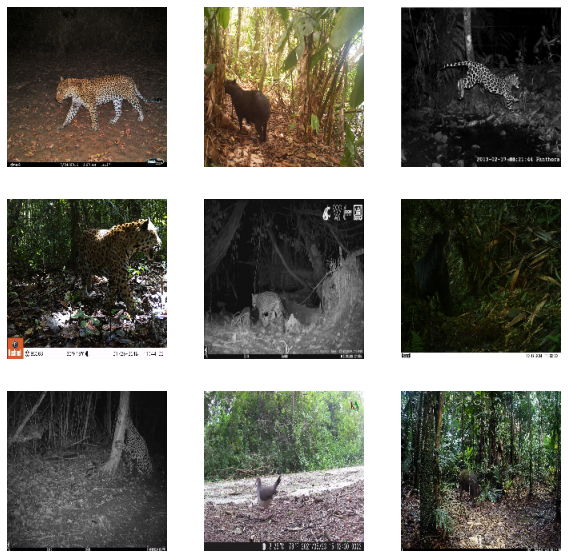

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(50, 200, 200, 3)
(50,)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
# Standarize the data
normalization_layer = layers.Rescaling(1./255)

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

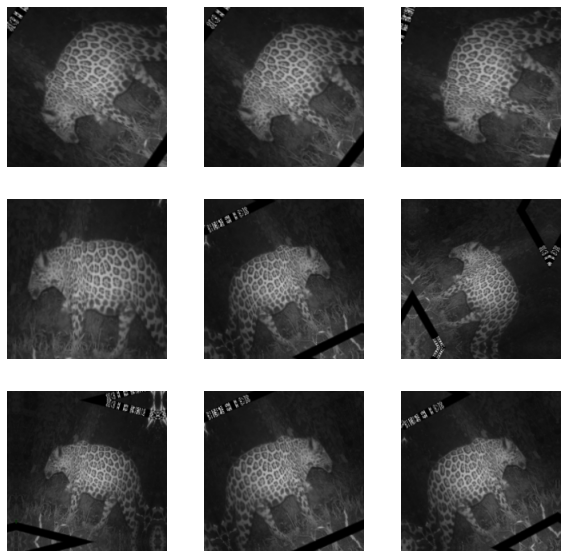

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [23]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
    
  layers.Conv2D(16, 1, padding='same', activation='relu',input_shape=(1, 200, 200)),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='sigmoid')
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      64        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      544       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                  

In [26]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
12/12 [==============================] - 13s 987ms/step - loss: 0.8133 - accuracy: 0.5954 - val_loss: 0.9132 - val_accuracy: 0.5000
Epoch 2/50
12/12 [==============================] - 9s 777ms/step - loss: 0.6724 - accuracy: 0.6007 - val_loss: 0.6321 - val_accuracy: 0.7627
Epoch 3/50
12/12 [==============================] - 9s 773ms/step - loss: 0.6413 - accuracy: 0.6453 - val_loss: 0.6952 - val_accuracy: 0.5127
Epoch 4/50
12/12 [==============================] - 9s 767ms/step - loss: 0.6365 - accuracy: 0.6613 - val_loss: 0.6372 - val_accuracy: 0.5805
Epoch 5/50
12/12 [==============================] - 10s 826ms/step - loss: 0.6342 - accuracy: 0.6506 - val_loss: 0.6364 - val_accuracy: 0.5975
Epoch 6/50
12/12 [==============================] - 9s 737ms/step - loss: 0.6268 - accuracy: 0.6506 - val_loss: 0.6513 - val_accuracy: 0.5890
Epoch 7/50
12/12 [==============================] - 9s 751ms/step - loss: 0.6246 - accuracy: 0.6684 - val_loss: 0.6151 - val_accuracy: 0.6695
Epoc

In [27]:
model.save('train_w/idea1/exp1_app2.h5')

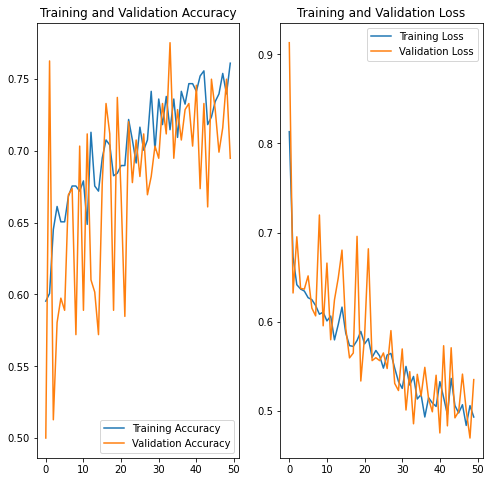

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()